# Power demand clustering

In [434]:
import pandas as pd

In [436]:
power = pd.read_csv('January_2013.csv')

In [438]:
power['Date'] = pd.to_datetime(power['Date'])

In [440]:
power.shape

(15095, 146)

## 1. Data-processing

In [486]:
#i)
# Selected columns with power data, 00:00 to 23:50. The first two were metadata.
# Dividing each value by the highest value in its corresponding row.
power_normalised = power.iloc[:, 2:].div(power.iloc[:, 2:].max(axis=1), axis=0)

# Adding back the Date and Substation Column
power_normalised["Date"] = power["Date"]
power_normalised["Substation"] = power["Substation"]

# Placing Date and Substation before the power data.
power_normalised = power_normalised[["Date", "Substation"] + list(power.columns[2:])]

print(power_normalised.head(2))

        Date  Substation     00:00     00:10     00:20     00:30     00:40  \
0 2013-01-03      511016  0.596742  0.602990  0.614149  0.610801  0.575764   
1 2013-01-03      511029  0.624220  0.722846  0.754057  0.643571  0.802122   

      00:50     01:00     01:10  ...     22:20     22:30     22:40     22:50  \
0  0.554787  0.565276  0.535148  ...  0.757867  0.769917  0.737782  0.710333   
1  0.834582  0.843321  0.818976  ...  0.655119  0.630774  0.647940  0.640762   

      23:00     23:10     23:20     23:30     23:40     23:50  
0  0.675073  0.686454  0.680875  0.671502  0.635126  0.603883  
1  0.637328  0.659800  0.631086  0.634519  0.687266  0.680400  

[2 rows x 146 columns]


In [488]:
# ii)

# Filter out weekends (Saturday=5, Sunday=6)
power_weekdays = power_normalised[power_normalised['Date'].dt.weekday < 5]

In [490]:
# iii)
# Average daily power demand profiles

# Group by Substation and calculate the mean for each 10-minute interval
average_daily_profile = (
    power_weekdays.groupby("Substation")
    .mean(numeric_only=True)
)

print(avg_daily_profile.head(2))

               00:00     00:10     00:20     00:30     00:40     00:50  \
Substation                                                               
511016      0.591735  0.596037  0.577479  0.567874  0.560374  0.552640   
511029      0.571221  0.641650  0.672472  0.695803  0.752872  0.740979   

               01:00     01:10     01:20     01:30  ...     22:30     22:40  \
Substation                                          ...                       
511016      0.544367  0.531079  0.523659  0.511897  ...  0.742951  0.721639   
511029      0.729712  0.710950  0.700275  0.685422  ...  0.720871  0.686436   

               22:50     23:00     23:10     23:20     23:30     23:40  \
Substation                                                               
511016      0.714996  0.709921  0.694241  0.675090  0.654038  0.629824   
511029      0.678937  0.660703  0.643323  0.630763  0.615327  0.609636   

               23:50  Cluster  
Substation                     
511016      0.613609     

## 2. Hierarchical Clustering

i) Euclidean Distance Matrix - Clustermap

In [448]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

In [492]:
# Calculate the distance matrix (Euclidean distance)
distance_matrix = squareform(pdist(avg_daily_profile, metric="euclidean"))
distance_df = pd.DataFrame(
    distance_matrix,
    index=avg_daily_profile.index,
    columns=avg_daily_profile.index
)

C:\Users\james\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\james\anaconda3\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
C:\Users\james\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\james\anaconda3\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


<Figure size 1200x1000 with 0 Axes>

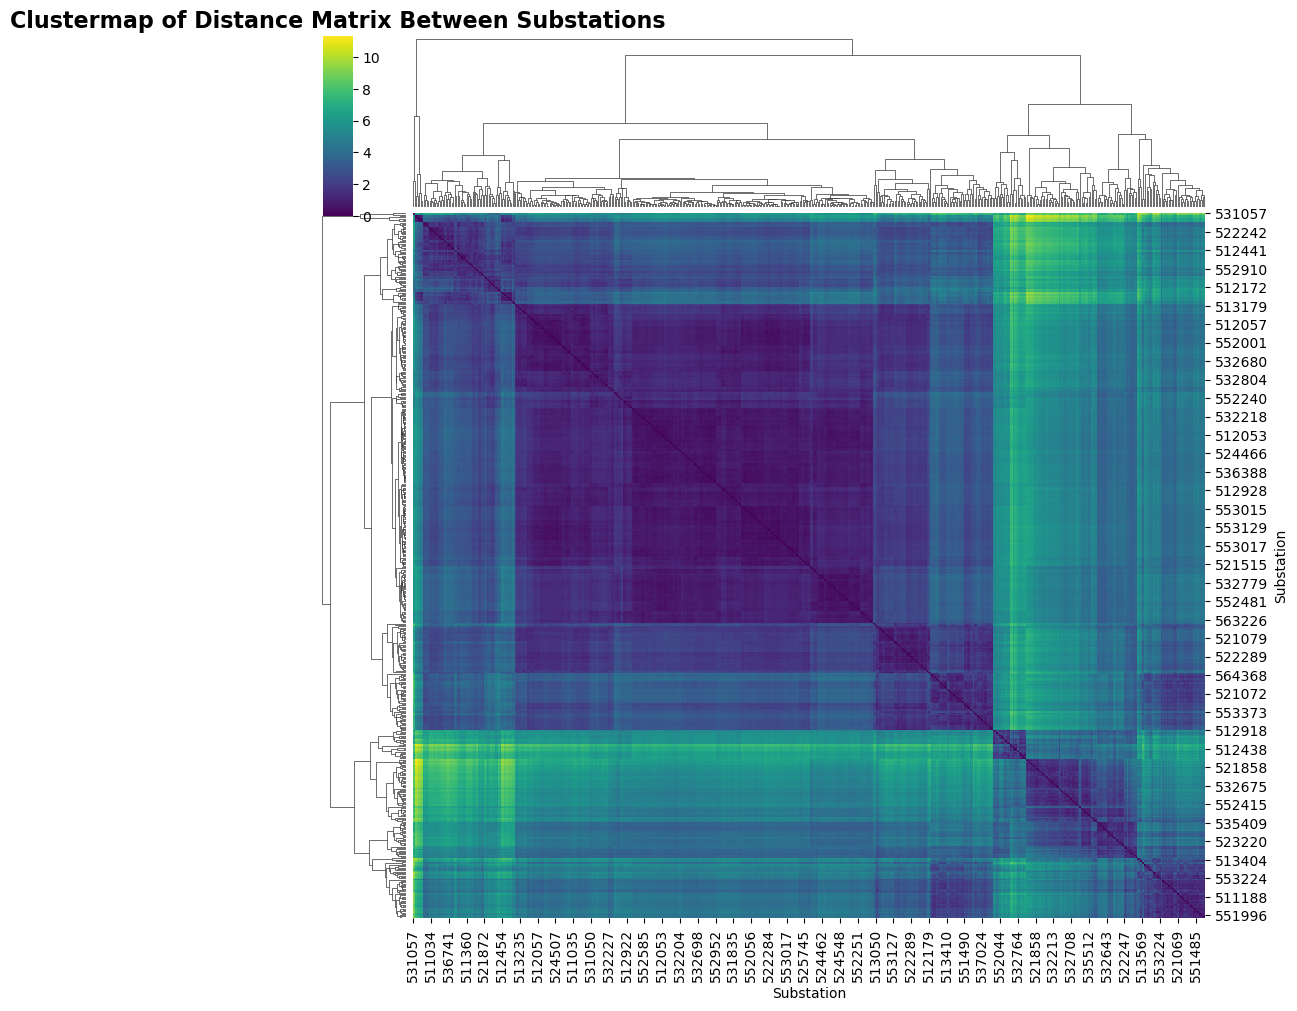

In [494]:
plt.figure(figsize=(12, 10))
sns.clustermap(
    distance_df,
    cmap='viridis',
    row_cluster=True,
    col_cluster=True,
    dendrogram_ratio=(0.1, 0.2),
    cbar_pos=(0.02, 0.8, 0.03, 0.18)
)
plt.title("Clustermap of Distance Matrix Between Substations", fontsize=16, fontweight='bold')

plt.show()

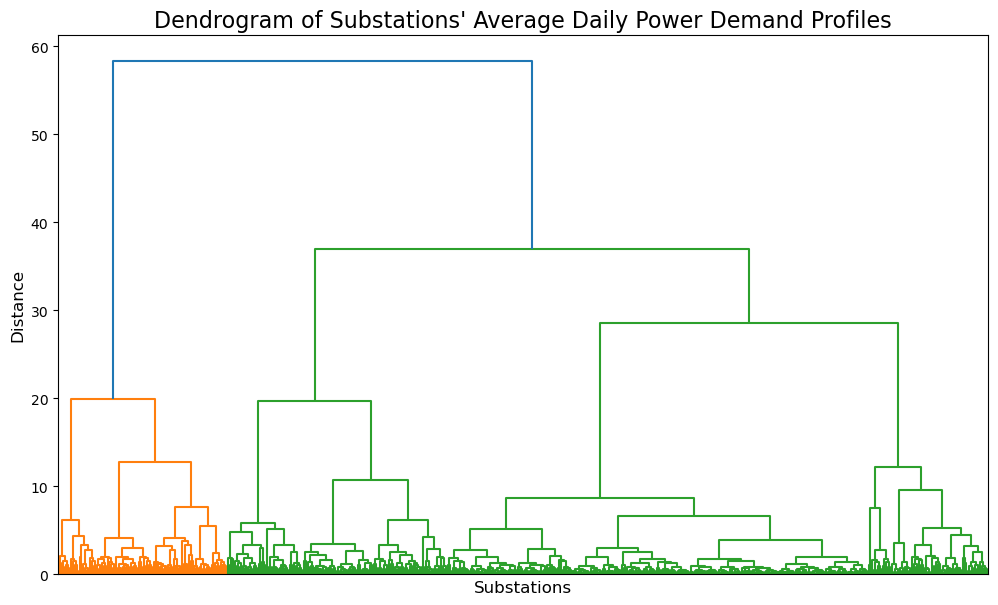

In [496]:
linkage_matrix = linkage(avg_daily_profile, method="ward")

plt.figure(figsize=(12, 7))
dendrogram(linkage_matrix, no_labels=True)

plt.title("Dendrogram of Substations' Average Daily Power Demand Profiles", fontsize=16)
plt.ylabel("Distance", fontsize=12)
plt.xlabel("Substations", fontsize=12)

plt.show()

For linkage, I decided to chose the Ward method because it minimises the total within-cluster variance, making it suitable for compact and well-separated clusters. It works well as I expected clusters to form around similar demand profiles.

## ii) 

From looking at the dendrogram above, we can see there are distict clusters forming around the distance 15.
I count 6 clusters at this level. I chose this level as there is the most clear separation at a level which still contains detail.

In [458]:
from scipy.cluster.hierarchy import fcluster

# Threshold distance
cluster_labels = fcluster(linkage_matrix, t=6, criterion="maxclust")  # 6 clusters

# Cluster labels.
avg_daily_profile["Cluster"] = cluster_labels

cluster_counts = avg_daily_profile["Cluster"].value_counts()
print(cluster_counts)


Cluster
5    242
4     83
2     75
6     69
3     44
1     22
Name: count, dtype: int64


The above table represents the amount of substations in each of their respective clusters. With cluster three being the largest, grouping 242 substations.

## iii)

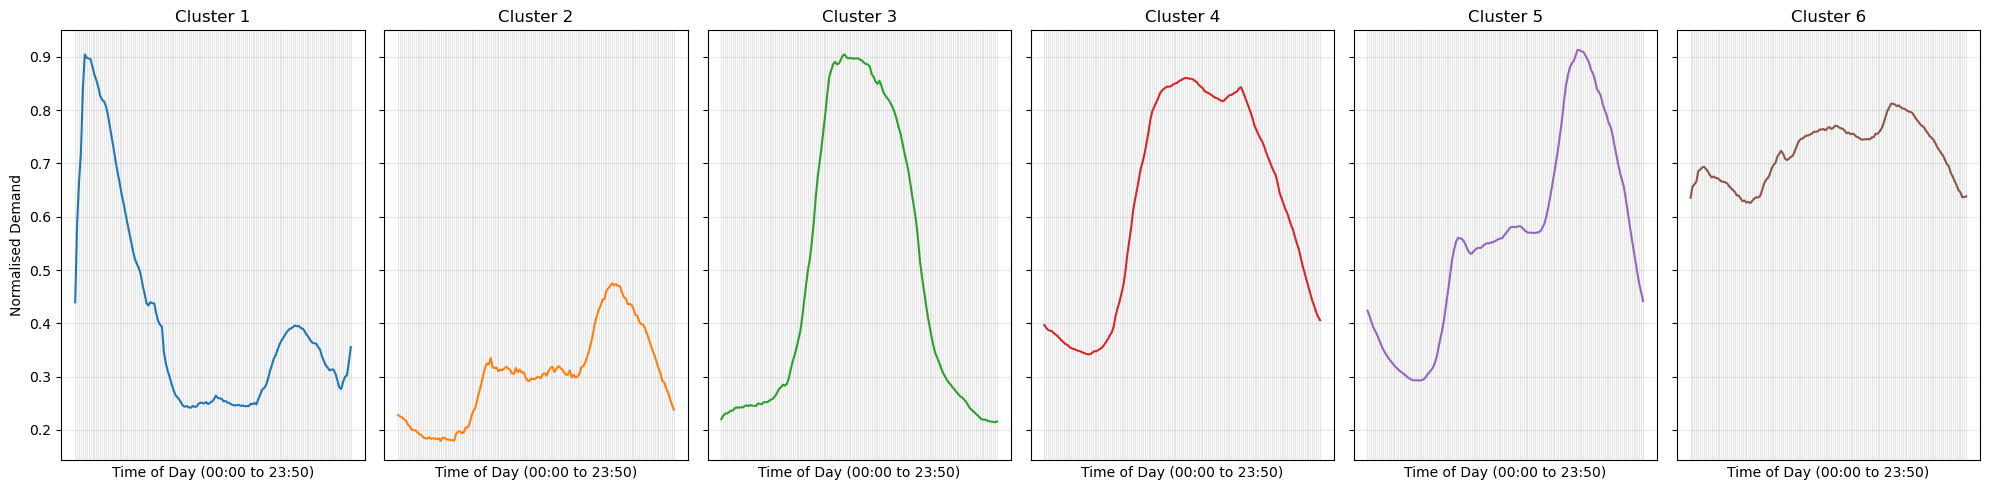

In [498]:
n_clusters = 6
cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

cluster_profiles = avg_daily_profile.groupby('Cluster').mean()

if 'Cluster' in cluster_profiles.columns:
    cluster_profiles = cluster_profiles.drop(columns=['Cluster'])

fig, axes = plt.subplots(1, n_clusters, figsize=(20, 5), sharey=True)

for i, ax in enumerate(axes, start=1):
    ax.plot(
        cluster_profiles.columns,
        cluster_profiles.loc[i], 
        label=f"Cluster {i}",
        color=f"C{i-1}"
    )
    ax.set_title(f"Cluster {i}")
    ax.set_xlabel("Time of Day (00:00 to 23:50)")
    if i == 1:
        ax.set_ylabel("Normalised Demand")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

plt.tight_layout()
plt.show()

## 3. Cluster Evaluation

In [462]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [466]:
# Compute silhouette scores
silhouette_avg = silhouette_score(avg_daily_profile, cluster_labels)
silhouette_vals = silhouette_samples(avg_daily_profile, cluster_labels)

print(f"Average Silhouette Score: {silhouette_avg:.3f}")

Average Silhouette Score: 0.448


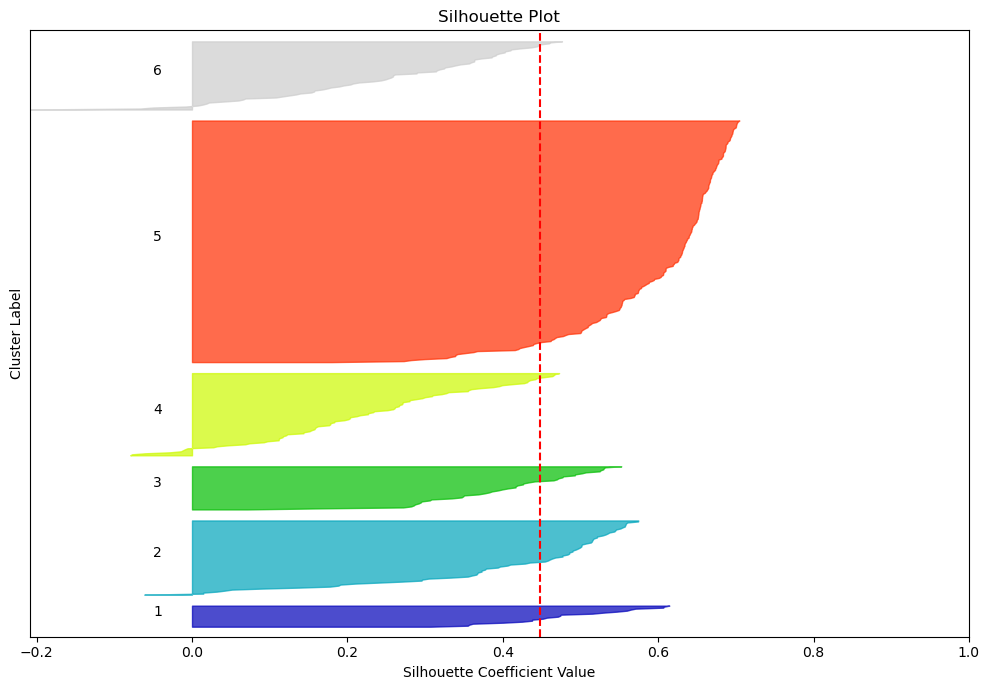

Average Silhouette Score: 0.448


In [502]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_vals = silhouette_samples(avg_daily_profile, cluster_labels)
silhouette_avg = silhouette_score(avg_daily_profile, cluster_labels)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(10, 7)

ax1.set_xlim([silhouette_vals.min(), 1])
n_clusters = 6 
ax1.set_ylim([0, avg_daily_profile.shape[0] + (n_clusters + 1) * 10])
y_lower = 10

for i in range(1, n_clusters + 1):
    ith_cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    ith_cluster_silhouette_vals.sort()

    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)

    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_vals,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_title("Silhouette Plot")
ax1.set_xlabel("Silhouette Coefficient Value")
ax1.set_ylabel("Cluster Label")

ax1.set_yticks([])

plt.tight_layout()
plt.show()

print(f"Average Silhouette Score: {silhouette_avg:.3f}")

In [2]:
print("The average silhouette_score is :", silhouette_avg)

NameError: name 'silhouette_avg' is not defined

The Silhouette plot displays that clusters one, three and five are appropriately clustered. Whilst, clusters two, four and six show very slight boardering neighboughing clusters. Despite this, the graph indicates that these clusters have a strong structure, as shown by their width, perticualrly cluster three and six.

## 4. Giving context

Looking at the subplots of daily average demand profiles of each cluster. We can observe the uniqueness of each cluster. 

Cluster One, these substations have an extreme surge in their daily power demand (0.9) from the early hours of the way and this steeply falls off after a few hours (0.25). The extremeness of this graph may be due to the lack of substations in the cluster, only 22.

Cluster Two, on average has the lowest average power demand. Reaching a peak of 0.47, but avareging around 0.3

Following Cluster Five, a similar pattern to cluster Two, but maintaining a very high level of demand and reaching a peak over 0.9.

Cluster Six has the least voltility in shape, maintaining a demand level of around 0.7

Cluster Three and Cluster Four have a simialr shape, resempling one of a normal distribution. However, Three has a much steeper rise and falls within an hour or, whereas, Four has a higher base level demand, a slower climb to its peak demand and a slower reducting on demand.